In [1]:
%matplotlib inline

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from  PIL import Image

import tensorflow as tf
import IPython.display as display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

import os, pathlib, math, datetime, errno

In [2]:
# graphwiz path variable
os.environ["PATH"] = os.environ["PATH"] + os.pathsep + "D:/Program Files (x68)/Graphwiz2.38/bin/"

# autotune constant
autotune = tf.data.experimental.AUTOTUNE

## Download the dataset using Kaggle API

```kaggle datasets download -d prasunroy/natural-images```

In [3]:
path = "C:\\Users\Ridzuan\.keras\datasets\\"
dir_name = "natural_images"
data_dir = pathlib.Path(path + dir_name)

print("Data directory : ", data_dir)
print("Content : ", os.listdir(data_dir))

Data directory :  C:\Users\Ridzuan\.keras\datasets\natural_images
Content :  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


## Random sampling

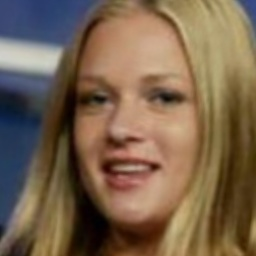

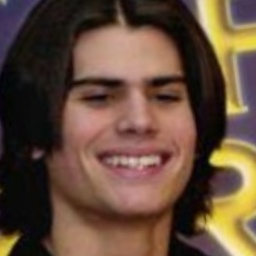

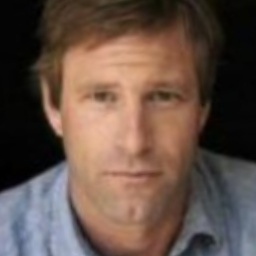

<Figure size 720x432 with 0 Axes>

In [4]:
persons = list(
   data_dir.glob("person/*")
)

plt.figure(figsize = (10, 6))
for image_path in persons[:3]:
   display.display(Image.open(str(image_path)))

## Image statistics

In [5]:
size_images = dict()
for dirpath, _, filenames in os.walk(data_dir):
   for path_image in filenames:
      image = os.path.abspath(os.path.join(dirpath, path_image))
      with Image.open(image) as image:
         width, height = image.size
         size_images[path_image] = {
            "width": width,
            "height": height
         }

In [6]:
df_size_images = pd.DataFrame(size_images).T
data_statistics = df_size_images.describe()
data_statistics

,width,height
count,6897.000000,6897.000000
mean,234.292446,197.540235
std,131.418515,123.580871
min,43.000000,50.000000
25%,100.000000,100.000000
50%,231.000000,122.000000
75%,295.000000,256.000000
max,1111.000000,1012.000000


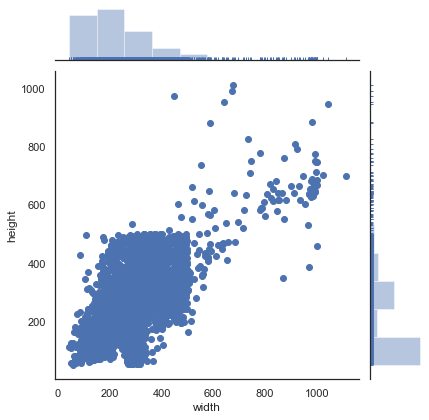

In [7]:
sns.set(style = "white", color_codes = True)
sns.jointplot(
   x = "width",
   y = "height",
   data = df_size_images,
   marginal_kws = dict(bins =10, rug = True)
)

## Outlier removal

In [8]:
df_size_images["width"].argmax()

d:\jupyter_notebook\virtualenv_keras\keras\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


'flower_0335.jpg'

In [9]:
df_size_images["height"].argmax()

d:\jupyter_notebook\virtualenv_keras\keras\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


'flower_0299.jpg'

In [10]:
outliers = [
   "flower_0339.jpg",
   "flower_0211.jpg"
]

def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occurred

for image in outliers:
   silentremove(image)

In [11]:
size_images = dict()
for root, dirs, filenames in os.walk(data_dir):
   for file in filenames:
      for outlier in outliers:
         if file.endswith(outlier):
            silentremove(root + "/" + str(file))

In [12]:
size_images = dict()
for root, dirs, filenames in os.walk(data_dir):
   for file in filenames:
      for outlier in outliers:
         if file.endswith(outlier):
            print(root + "/" + str(file))

In [13]:
size_images = dict()
for dirpath, _, filenames in os.walk(data_dir):
   for path_image in filenames:
      image = os.path.abspath(os.path.join(dirpath, path_image))
      with Image.open(image) as image:
         width, height = image.size
         size_images[path_image] = {
            "width": width,
            "height": height
         }

In [14]:
df_size_images = pd.DataFrame(size_images).T
data_statistics = df_size_images.describe()
data_statistics

,width,height
count,6897.000000,6897.000000
mean,234.292446,197.540235
std,131.418515,123.580871
min,43.000000,50.000000
25%,100.000000,100.000000
50%,231.000000,122.000000
75%,295.000000,256.000000
max,1111.000000,1012.000000


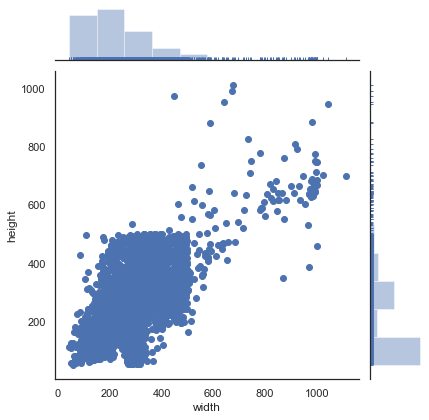

In [15]:
sns.set(style = "white", color_codes = True)
sns.jointplot(
   x = "width",
   y = "height",
   data = df_size_images,
   marginal_kws = dict(bins =10, rug = True)
)

In [16]:
class_names = np.array([
   item.name for item in data_dir.glob("*")
])

print(class_names)

['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


In [17]:
list_dataset = tf.data.Dataset.list_files(
   str(data_dir/"*/*")
)

for f in list_dataset.take(3):
   print(f.numpy())

b'C:\\Users\\Ridzuan\\.keras\\datasets\\natural_images\\cat\\cat_0223.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\natural_images\\cat\\cat_0777.jpg'
b'C:\\Users\\Ridzuan\\.keras\\datasets\\natural_images\\flower\\flower_0770.jpg'


In [50]:
batch_size = 32
img_width = int(data_statistics["width"]["mean"])
img_height = int(data_statistics["height"]["mean"])

def get_label(file_path):
   parts = tf.strings.split(file_path, os.path.sep)
   return parts[-2] == class_names

def decode_image(img):
   img = tf.image.decode_jpeg(img, channels = 3)
   img = tf.image.convert_image_dtype(img, tf.float32)
   return tf.image.resize(img, [img_width, img_height])

def process_path(file_path):
   label = get_label(file_path)
   img = tf.io.read_file(file_path)
   img = decode_image(img)
   return img, label

In [51]:
labeled_ds = list_dataset.map(
   process_path,
   num_parallel_calls = autotune
)

In [52]:
for image, label in labeled_ds.take(1):
   print("Image shape: ", image.numpy().shape)
   print("Label", label)

Image shape:  (234, 197, 3)
Label tf.Tensor([False False False  True False False False False], shape=(8,), dtype=bool)


In [22]:
def prepare_for_training(dataset, cache = True, shuffle_buffer_size = 1000):
   if cache:
      if isinstance(cache, str):
         dataset = dataset.cache(cache)
      else:
         dataset = dataset.cache()
         
      dataset = dataset.shuffle(buffer_size = shuffle_buffer_size).repeat().batch(batch_size).prefetch(buffer_size = autotune)
      return dataset

In [23]:
prepared_train_data = prepare_for_training(labeled_ds)
prepared_test_data = prepare_for_training(labeled_ds)

In [24]:
# random sampling and display

def show_batch(image_batch, label_batch):
   plt.figure(figsize = (10, 10))
   for n in range(4):
      plt.subplot(4, 1, n + 1)
      plt.imshow(image_batch[n])
      plt.axis("off")

In [25]:
# image_batch, label_batch = next(iter(prepared_train_data))
# show_batch(image_batch, label_batch)

In [26]:
model = Sequential([
   Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_width, img_height, 3)),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(32, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(64, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(128, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Flatten(),
   Dense(512, activation='relu'),
   Dense(8, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

logdir = os.path.join(
   "logs\\intel_dataset",
   datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
   logdir,
   histogram_freq = 1
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 234, 197, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 117, 98, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 117, 98, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 98, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 49, 64)        1

In [28]:
history = model.fit(
   prepared_train_data,
   epochs = 20,
   steps_per_epoch = 100,
   validation_data = prepared_test_data,
   validation_steps = 100,
   callbacks = [tensorboard_callback]
)

Train for 100 steps, validate for 100 steps
Epoch 1/20
100/100 [==============================] - 131s 1s/step - loss: 0.3223 - accuracy: 0.8913 - val_loss: 0.2062 - val_accuracy: 0.9277
Epoch 2/20
100/100 [==============================] - 147s 1s/step - loss: 0.1456 - accuracy: 0.9427 - val_loss: 0.1049 - val_accuracy: 0.9605
Epoch 3/20
100/100 [==============================] - 167s 2s/step - loss: 0.0979 - accuracy: 0.9613 - val_loss: 0.0748 - val_accuracy: 0.9721
Epoch 4/20
100/100 [==============================] - 173s 2s/step - loss: 0.0816 - accuracy: 0.9671 - val_loss: 0.0681 - val_accuracy: 0.9738
Epoch 5/20
100/100 [==============================] - 174s 2s/step - loss: 0.0663 - accuracy: 0.9732 - val_loss: 0.0603 - val_accuracy: 0.9776
Epoch 6/20
100/100 [==============================] - 178s 2s/step - loss: 0.0611 - accuracy: 0.9746 - val_loss: 0.0580 - val_accuracy: 0.9785
Epoch 7/20
100/100 [==============================] - 175s 2s/step - loss: 0.0516 - accuracy: 0.97

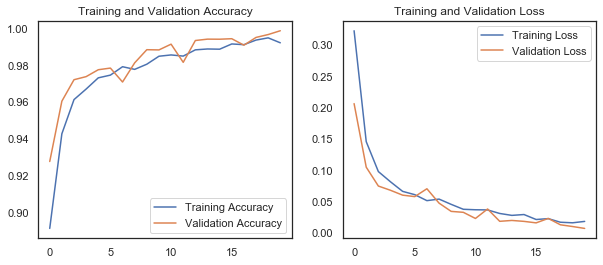

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
from sklearn.metrics import classification_report

image_batch, label_batch = next(iter(prepared_test_data))

y_pred = model.predict(image_batch, batch_size = 20, verbose=1)
y_pred_bool = np.argmax(label_batch, axis=1)

print(classification_report(label_batch.numpy().nonzero()[1], y_pred_bool))

32/32 [==============================] - 0s 7ms/sample
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [43]:
y_pred_bool

array([2, 7, 0, 7, 2, 0, 1, 6, 5, 7, 5, 1, 4, 3, 6, 2, 5, 7, 7, 0, 7, 0,
       6, 4, 0, 5, 6, 7, 3, 5, 1, 3], dtype=int64)

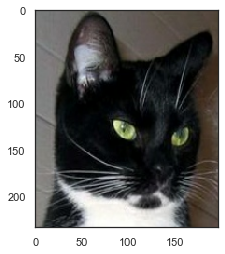

In [39]:
plt.figure()
plt.imshow(image_batch[0])